In [1]:
%load_ext autoreload
import numpy as np
import os
import plotly.graph_objects as go
from kernels import IonRate
from field_functions import LaserField

from plotting import plotter

class AU:
    meter = 5.2917720859e-11 # atomic unit of length in meters
    nm = 5.2917721e-2 # atomic unit of length in nanometres
    second = 2.418884328e-17 # atomic unit of time in seconds
    fs = 2.418884328e-2 # atomic unit of time in femtoseconds
    Joule = 4.359743935e-18 # atomic unit of energy in Joules
    eV = 27.21138383 # atomic unit of energy in electronvolts
    Volts_per_meter = 5.142206313e+11 # atomic unit of electric field in V/m
    Volts_per_Angstrom = 51.42206313 # atomic unit of electric field in V/Angström
    speed_of_light = 137.035999 # vacuum speed of light in atomic units
    Coulomb = 1.60217646e-19 # atomic unit of electric charge in Coulombs
    PW_per_cm2_au = 0.02849451308 # PW/cm^2 in atomic units
AtomicUnits=AU

params = {'E_g': 0.5, 'αPol': 4.51, "div_p":2**-4*2, "div_theta":1, 'lam0': 850, 'intensity': 1e14, 'cep': 0}

In [2]:
%autoreload
laser_pulses = LaserField(cache_results=True)
laser_pulses.add_pulse(params['lam0'], params['intensity'], params['cep'], params['lam0']/ AtomicUnits.nm / AtomicUnits.speed_of_light)
t_min, t_max = laser_pulses.get_time_interval()
time_recon= np.arange(int(t_min), int(t_max)+1, 1.)

rate_SFA = IonRate(time_recon, laser_pulses, params, dT=0.5, kernel_type='exact_SFA')
laser_pulses.reset()

In [14]:
%autoreload
laser_pulses = LaserField(cache_results=True)
laser_pulses.add_pulse(params['lam0'], params['intensity'], params['cep'], params['lam0']/ AtomicUnits.nm / AtomicUnits.speed_of_light)
t_min, t_max = laser_pulses.get_time_interval()
time_recon= np.arange(int(t_min), int(t_max)+1, 1.)
# to save computation time we can neglect cross terms!! just look at formula for <p|d|psi> there is i^l and because of the transition rules l has to be +-1 so if we sum over all states and one is complex conjugatet and we sum it up they will cancel out !!! but be carefull we only can use states that are allowed theoretically

rateExcited = IonRate(time_recon, laser_pulses, params, dT=0.5, kernel_type='exact_SFA', excitedStates=3, coeffType="numerical", gauge="length", get_p_only=True, only_c0_is_1_rest_normal=False)
rateExcited_1 = IonRate(time_recon, laser_pulses, params, dT=0.5, kernel_type='exact_SFA', excitedStates=1, coeffType="numerical", gauge="length", get_p_only=True, only_c0_is_1_rest_normal=True)
rateExcited_c0is1 = IonRate(time_recon, laser_pulses, params, dT=0.5, kernel_type='exact_SFA', excitedStates=3, coeffType="numerical", gauge="length", get_p_only=True, only_c0_is_1_rest_normal=True)
laser_pulses.reset()

Basis states (6): [(1, 0, 0), (2, 0, 0), (2, 1, 0), (3, 0, 0), (3, 1, 0), (3, 2, 0)]
Basis states (6): [(1, 0, 0), (2, 0, 0), (2, 1, 0), (3, 0, 0), (3, 1, 0), (3, 2, 0)]
Basis states (6): [(1, 0, 0), (2, 0, 0), (2, 1, 0), (3, 0, 0), (3, 1, 0), (3, 2, 0)]


In [ ]:
%autoreload
laser_pulses = LaserField(cache_results=True)
laser_pulses.add_pulse(params['lam0'], params['intensity'], params['cep'], params['lam0']/ AtomicUnits.nm / AtomicUnits.speed_of_light)
t_min, t_max = laser_pulses.get_time_interval()
time_recon= np.arange(int(t_min), int(t_max)+1, 1.)
# to save computation time we can neglect cross terms!! just look at formula for <p|d|psi> there is i^l and because of the transition rules l has to be +-1 so if we sum over all states and one is complex conjugatet and we sum it up they will cancel out !!! but be carefull we only can use states that are allowed theoretically

rateExcited_1 = IonRate(time_recon, laser_pulses, params, dT=0.5, kernel_type='exact_SFA', excitedStates=1, coeffType="numerical", gauge="length", get_p_only=True, only_c0_is_1_rest_normal=True)
laser_pulses.reset()

Basis states (6): [(1, 0, 0), (2, 0, 0), (2, 1, 0), (3, 0, 0), (3, 1, 0), (3, 2, 0)]


File /home/user/BachelorThesis/Bachelor-thesis/ionModel/python/plots/rate4_850_1.00e+14_onlystark.pdf already exists - skipping save


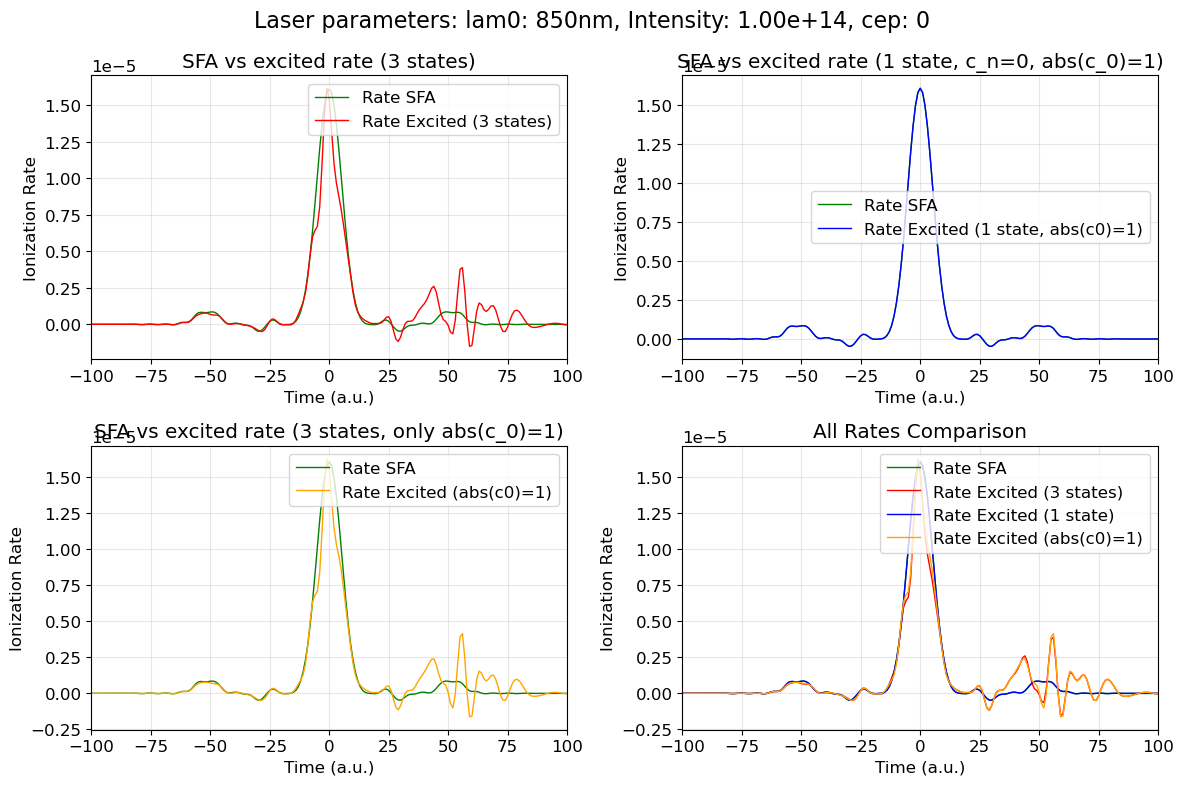

In [30]:
%autoreload
data = plotter(params, time_recon, rate_SFA, rateExcited, rateExcited_1, rateExcited_c0is1, useTex=False)

data.matplot4()

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=time_recon, y=rate_SFA, mode='lines', name='SFA'))
# fig.add_trace(go.Scatter(x=time_recon, y=np.real(rateExcited), mode='lines', name='SFA_numerical'))
# lam0 = params['lam0']
# intensity = params['intensity']
# fig.update_layout(
#     title=f'Ionization Rate for {lam0} nm, {intensity:.2e} W/cm²',
#     xaxis_title='Time (a.u.)',
#     yaxis_title='Ionization Rate (a.u.)',
#     legend=dict(x=0.01, y=0.99),
#     template='plotly_white',
#     xaxis_range=[-100, 100],
#     width=800,
#     height=600
# )
# # truncate y-axis
# fig.show()

# filename = f"plots/ionRate_{params['lam0']}_c0-is-1.html"
# if not os.path.exists(filename):
#     fig.write_html(filename)
#     print(f"Plot saved as {filename}")
# else:
#     print(f"File {filename} already exists - skipping save")